In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
df_test = pd.read_csv("/content/drive/MyDrive/NSL-KDD/KDDTest+.txt")
df_train = pd.read_csv("/content/drive/MyDrive/NSL-KDD/KDDTrain+.txt")

In [4]:
df_test.head()

,0,tcp,private,REJ,0.1,0.2,0.3,0.4,0.5,0.6,...,0.04.1,0.06.1,0.00.3,0.00.4,0.00.5,0.00.6,1.00.2,1.00.3,neptune,21
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21
2,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15
3,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11
4,0,tcp,http,SF,267,14515,0,0,0,0,...,1.00,0.00,0.01,0.03,0.01,0.0,0.00,0.00,normal,21


In [5]:
# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df_test.columns = columns
df_train.columns = columns

# sanity check
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21
2,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15
3,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11
4,0,tcp,http,SF,267,14515,0,0,0,0,...,1.00,0.00,0.01,0.03,0.01,0.0,0.00,0.00,normal,21


In [6]:
# map normal to 0, all attacks to 1
is_attack = df_train.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = df_test.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
df_train['attack_flag'] = is_attack
df_test['attack_flag'] = test_attack

# view the result
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21,1
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21,0
2,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15,1
3,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11,1
4,0,tcp,http,SF,267,14515,0,0,0,0,...,0.00,0.01,0.03,0.01,0.0,0.00,0.00,normal,21,0


In [7]:
# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','Privilege','Access']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in privilege_attacks:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in access_attacks:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0

    return attack_type

# map the data and join to the data set
attack_map = df_train.attack.apply(map_attack)
df_train['attack_map'] = attack_map

test_attack_map = df_test.attack.apply(map_attack)
df_test['attack_map'] = test_attack_map

# view the result
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21,1,1
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.02,0.00,0.0,0.00,0.00,normal,21,0,0
2,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.28,0.00,0.0,0.00,0.00,saint,15,1,2
3,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11,1,2
4,0,tcp,http,SF,267,14515,0,0,0,0,...,0.01,0.03,0.01,0.0,0.00,0.00,normal,21,0,0


In [8]:
# use a crosstab to get attack vs protocol
attack_vs_protocol = pd.crosstab(df_train.attack, df_train.protocol_type)
attack_vs_protocol

protocol_type,icmp,tcp,udp
attack,,,
back,0,956,0
buffer_overflow,0,30,0
ftp_write,0,8,0
guess_passwd,0,53,0
imap,0,11,0
ipsweep,3117,482,0
land,0,18,0
loadmodule,0,9,0
multihop,0,7,0


In [9]:
# helper function for drawing mulitple charts.
def bake_pies(data_list,labels):
    list_length = len(data_list)

    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}

    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)

    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list):

        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)

        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])

    return axs

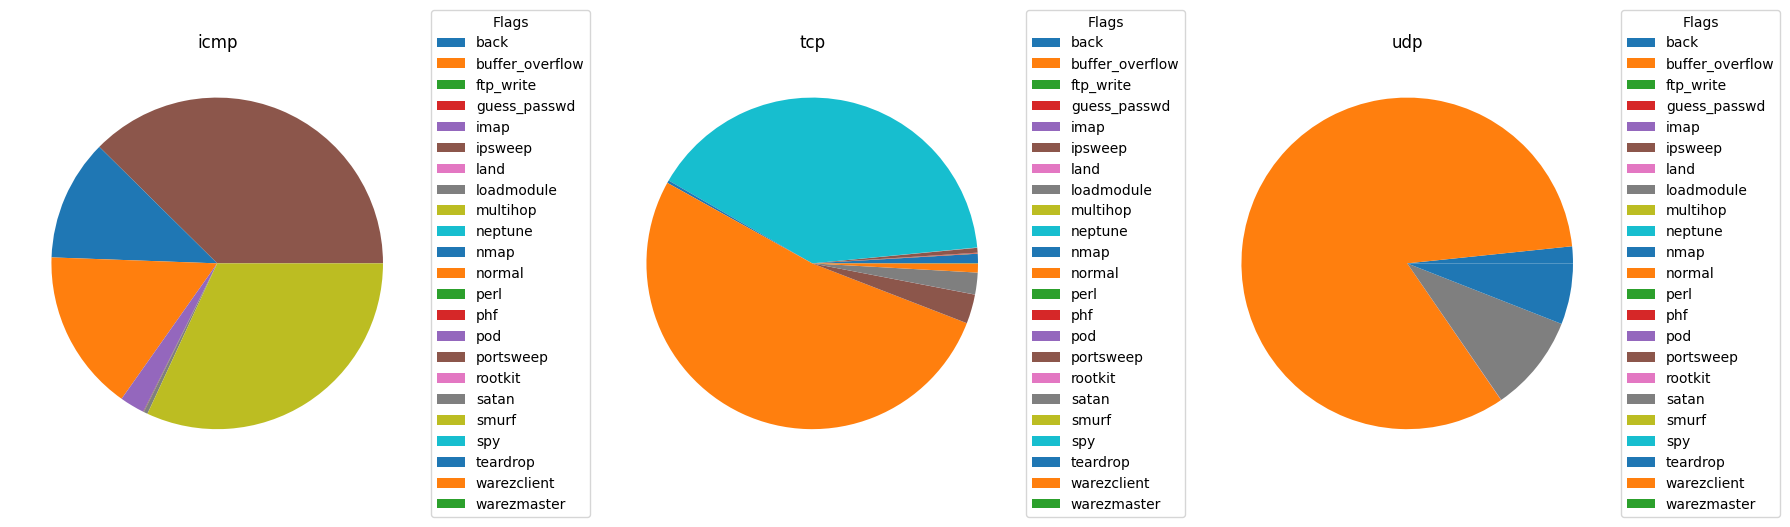

In [10]:
# get the series for each protocol
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

# create the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

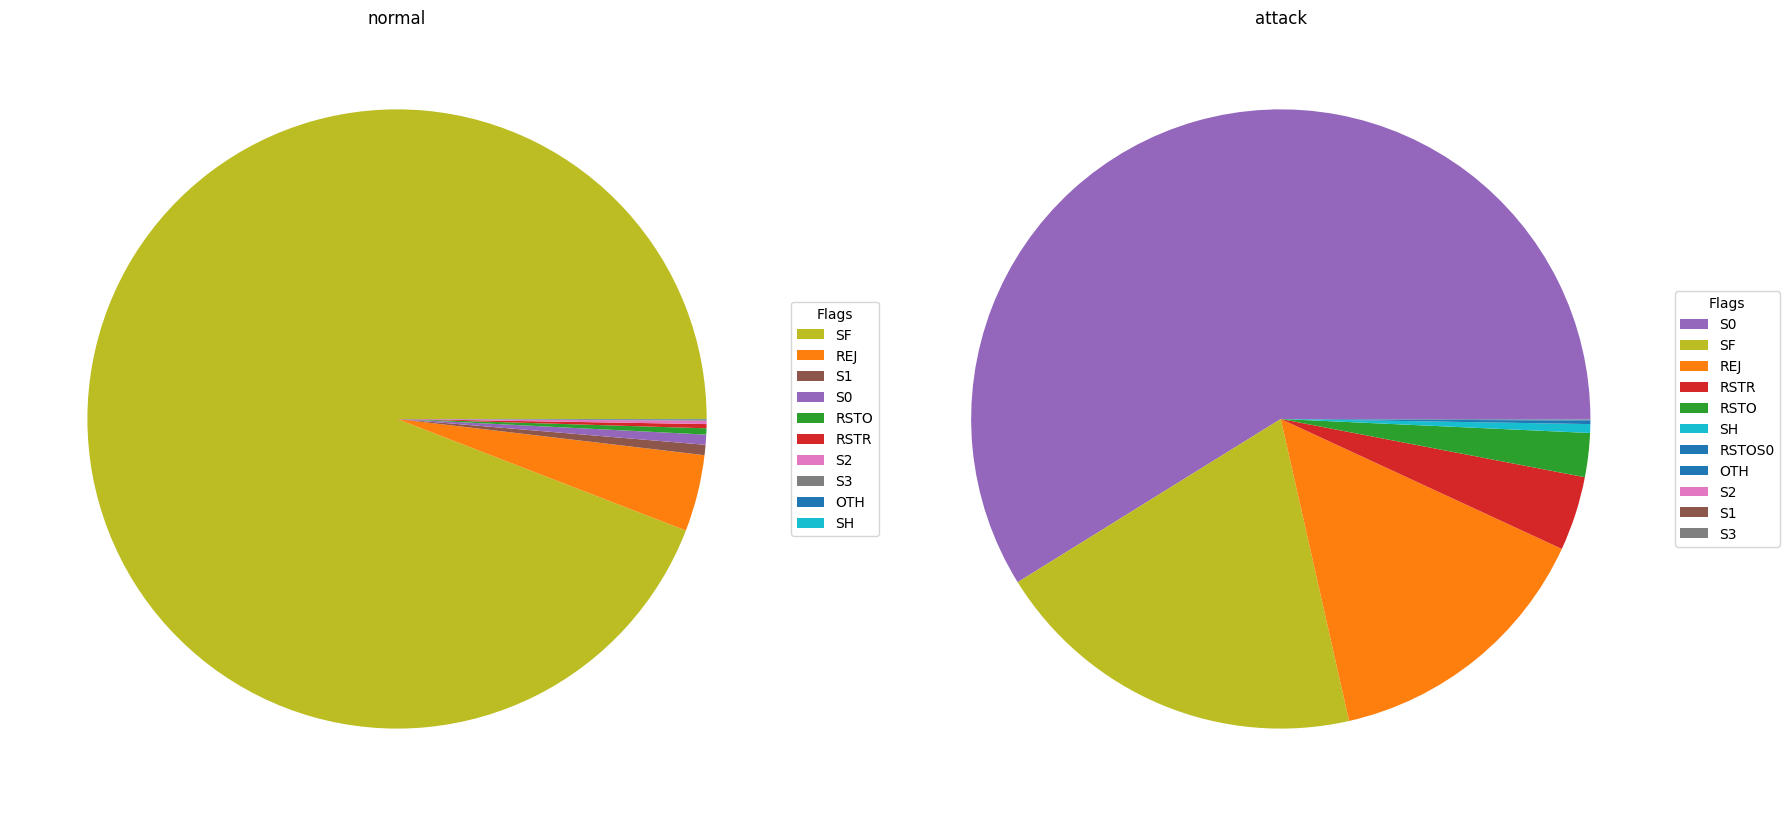

In [11]:
# get a series with the count of each flag for attack and normal traffic
normal_flags = df_train.loc[df_train.attack_flag == 0].flag.value_counts()
attack_flags = df_train.loc[df_train.attack_flag == 1].flag.value_counts()

# create the charts
flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'])
plt.show()

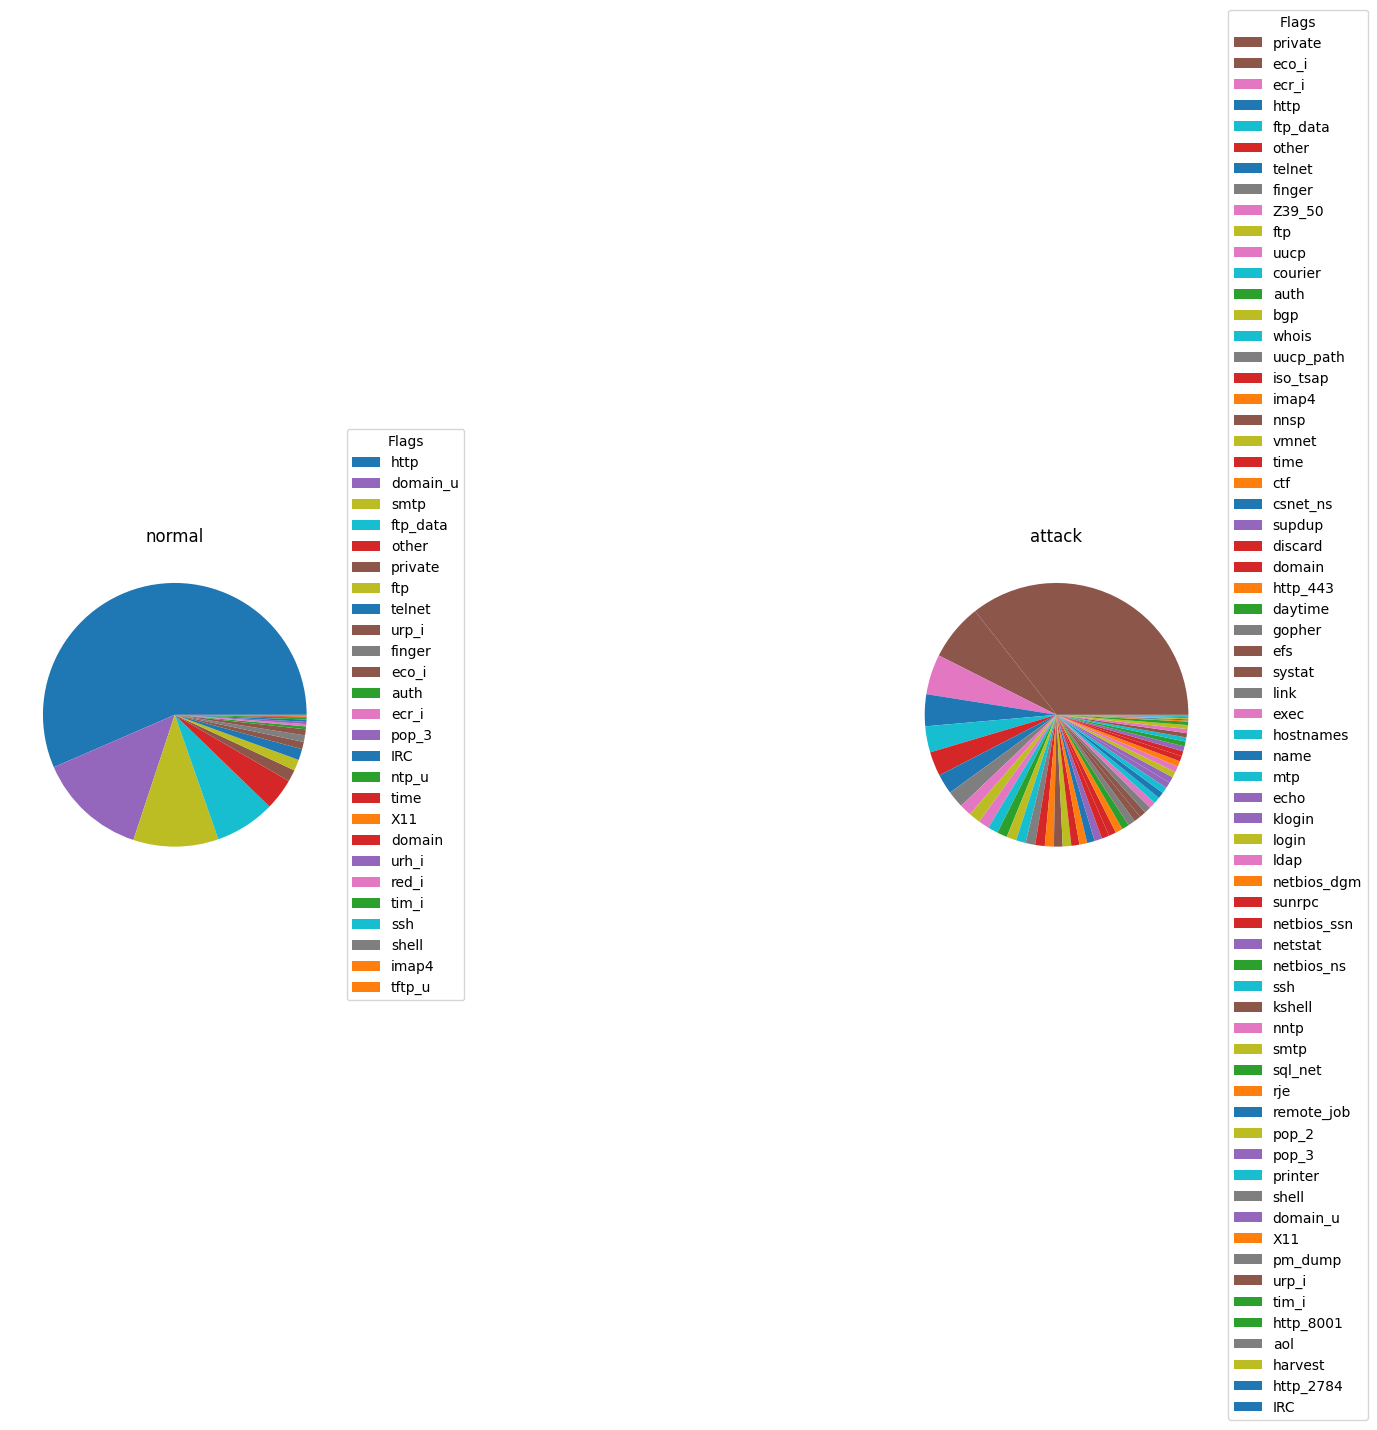

In [12]:
# get a series with the count of each service for attack and normal traffic
normal_services = df_train.loc[df_train.attack_flag == 0].service.value_counts()
attack_services = df_train.loc[df_train.attack_flag == 1].service.value_counts()

# create the charts
service_axs = bake_pies([normal_services, attack_services], ['normal','attack'])
plt.show()

In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 47 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

In [54]:
from sklearn.preprocessing import RobustScaler

def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df

In [57]:
cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'attack']
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    dataframe.loc[dataframe['attack'] == "normal", "attack"] = 0
    dataframe.loc[dataframe['attack'] != 0, "attack"] = 1

    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe

In [59]:
scaled_train = preprocess(df_train)

In [60]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 47 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   protocol_type                125972 non-null  object 
 1   service                      125972 non-null  object 
 2   flag                         125972 non-null  object 
 3   land                         125972 non-null  int64  
 4   logged_in                    125972 non-null  int64  
 5   is_host_login                125972 non-null  int64  
 6   is_guest_login               125972 non-null  int64  
 7   attack                       125972 non-null  object 
 8   level                        125972 non-null  int64  
 9   duration                     125972 non-null  float64
 10  src_bytes                    125972 non-null  float64
 11  dst_bytes                    125972 non-null  float64
 12  wrong_fragment               125972 non-null  float64
 13 

In [61]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [62]:
df_train.isnull().sum()

protocol_type                  0
service                        0
flag                           0
land                           0
logged_in                      0
is_host_login                  0
is_guest_login                 0
attack                         0
level                          0
duration                       0
src_bytes                      0
dst_bytes                      0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_r

In [63]:
df_test.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [64]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 47 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   protocol_type                125972 non-null  object 
 1   service                      125972 non-null  object 
 2   flag                         125972 non-null  object 
 3   land                         125972 non-null  int64  
 4   logged_in                    125972 non-null  int64  
 5   is_host_login                125972 non-null  int64  
 6   is_guest_login               125972 non-null  int64  
 7   attack                       125972 non-null  object 
 8   level                        125972 non-null  int64  
 9   duration                     125972 non-null  float64
 10  src_bytes                    125972 non-null  float64
 11  dst_bytes                    125972 non-null  float64
 12  wrong_fragment               125972 non-null  float64
 13 

In [65]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
df_train['Encoded_protocol_type'] = label_encoder.fit_transform(df_train['protocol_type'])
df_train['Encoded_protocol_service'] = label_encoder.fit_transform(df_train['service'])

df_test['Encoded_protocol_type'] = label_encoder.fit_transform(df_test['protocol_type'])
df_test['Encoded_protocol_service'] = label_encoder.fit_transform(df_test['service'])

In [66]:
# X와 y를 정의
X = df_train.drop(['attack', 'flag','protocol_type', 'service', 'attack_flag'], axis=1).values
y = df_train['attack_flag'].values

In [67]:
# 테스트 데이터셋의 준비
X_test = df_test.drop(['attack', 'flag','protocol_type', 'service', 'attack_flag'], axis=1).values
y_test = df_test['attack_flag'].values

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=21)

In [69]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [70]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

# Apply sequence transformation using time step of 25 for both train and test data
# All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity.

X_train, y_train = split_sequences(train_set, 5)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 5)
print(X_test.shape, y_test.shape)

(113370, 5, 42) (113370,)
(12594, 5, 42) (12594,)


In [71]:
from sklearn.preprocessing import MaxAbsScaler

# 변형 객체 생성
maxabs_scaler = MaxAbsScaler()

# 훈련데이터의 모수 분포 저장
# 시퀀스 변환 후에 2차원 배열로 변환하여 스케일링을 적용해야 함
X_train_reshaped = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
maxabs_scaler.fit(X_train_reshaped)

# 훈련 데이터 스케일링
X_train_scaled = maxabs_scaler.transform(X_train_reshaped)
# 2차원 배열을 다시 3차원 배열로 변환
X_train_scaled = X_train_scaled.reshape(X_train.shape)

# 테스트 데이터의 스케일링
# 시퀀스 변환 후에 2차원 배열로 변환하여 스케일링을 적용해야 함
X_test_reshaped = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
X_test_scaled = maxabs_scaler.transform(X_test_reshaped)
# 2차원 배열을 다시 3차원 배열로 변환
X_test_scaled = X_test_scaled.reshape(X_test.shape)

In [72]:

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((113370, 5, 42), (12594, 5, 42), (113370,), (12594,))

In [73]:
y_train_onehot = pd.get_dummies(y_train).values
y_test_onehot = pd.get_dummies(y_test).values

In [74]:

from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Input
from keras.layers import Dense, Flatten, Dropout
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense

In [75]:

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_onehot.shape[1]
print(n_timesteps, n_features, n_outputs)

5 42 2


In [76]:
input_layer = Input(shape=(n_timesteps, n_features))

conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
flat = Flatten()(conv1)
dens = Dense(64, activation="relu")(flat)
outputs = Dense(2, activation="sigmoid")(dens)

model = keras.Model(input_layer, outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 42)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 3, 64)             8128      
                                                                 
 flatten_4 (Flatten)         (None, 192)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                12352     
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 20,610
Trainable params: 20,610
Non-trainable params: 0
_________________________________________________________________


In [77]:
train_epochs = 30
history = model.fit(X_train, y_train_onehot, epochs=train_epochs, verbose=True,  validation_split = 0.1)

Epoch 1/30
3189/3189 [==============================] - 23s 7ms/step - loss: 9.3108 - accuracy: 0.9048 - val_loss: 7.0774 - val_accuracy: 0.9443
Epoch 2/30
3189/3189 [==============================] - 10s 3ms/step - loss: 7.2388 - accuracy: 0.9541 - val_loss: 9.2548 - val_accuracy: 0.9625
Epoch 3/30
3189/3189 [==============================] - 10s 3ms/step - loss: 8.5523 - accuracy: 0.9587 - val_loss: 12.1373 - val_accuracy: 0.9645
Epoch 4/30
3189/3189 [==============================] - 8s 3ms/step - loss: 11.1083 - accuracy: 0.9586 - val_loss: 6.3560 - val_accuracy: 0.9567
Epoch 5/30
3189/3189 [==============================] - 10s 3ms/step - loss: 4.8265 - accuracy: 0.9533 - val_loss: 4.9188 - val_accuracy: 0.9485
Epoch 6/30
3189/3189 [==============================] - 10s 3ms/step - loss: 1.9759 - accuracy: 0.9507 - val_loss: 2.3121 - val_accuracy: 0.9505
Epoch 7/30
3189/3189 [==============================] - 8s 3ms/step - loss: 1.6796 - accuracy: 0.9530 - val_loss: 2.9456 - val_ac

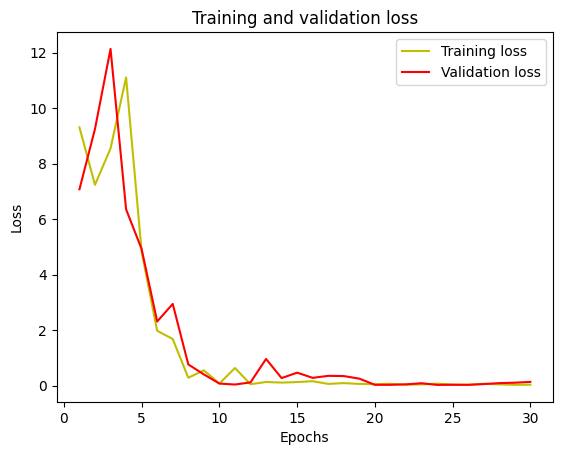

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

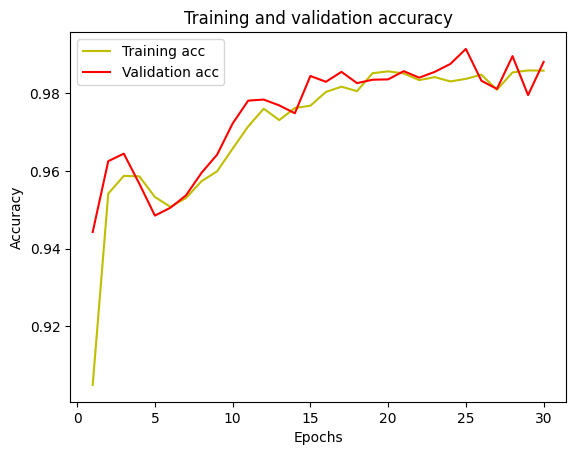

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [79]:
#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix


y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test_onehot,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

394/394 [==============================] - 1s 2ms/step


In [80]:

#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6746
           1       0.97      1.00      0.99      5848

    accuracy                           0.99     12594
   macro avg       0.99      0.99      0.99     12594
weighted avg       0.99      0.99      0.99     12594

[[6594  152]
 [   6 5842]]
